In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
sample_submission = pd.read_csv("sample_submission.csv")
print(test.shape)
print(train.shape)
train.head(4)

(28000, 784)
(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# First try random labels to set a baseline. Score: 0.09.

In [4]:
image_ids = test.index + 1
random_labels = np.random.choice(range(10), size=test.shape[0], replace=True)
submission = pd.DataFrame({'ImageId': image_ids, 'Label': random_labels})
submission.to_csv("submission.csv", index=False)
submission.shape

(28000, 2)

In [5]:
sample_submission.head(4)

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0


# Now try the easiest supervised learning algo.

In [6]:
X = train.drop('label', axis=1).values
y = train['label'].values
print(X.shape)
print(y.shape)

(42000, 784)
(42000,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

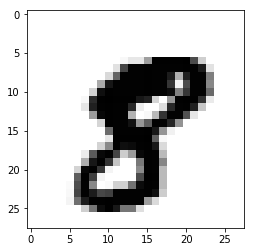

In [8]:
some_digit = X[10]
plt.imshow(some_digit.reshape(28, 28), cmap=matplotlib.cm.binary)

In [9]:
y_train_8 = (y_train == 8)
y_test_8 = (y_test == 8)

In [ ]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train, y_train_8)
sgd_clf.predict([some_digit])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train_8, cv=3, scoring='accuracy')

In [ ]:
from sklearn.base import BaseEstimator

class Never8Estimater(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_8_clf = Never8Estimater()
cross_val_score(never_8_clf, X_train, y_train_8, cv=3, scoring='accuracy')

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_8, cv=3)
confusion_matrix(y_train_8, y_train_pred)
precision_score(y_train_8, y_train_pred)
recall_score(y_train_8, y_train_pred)
f1_score(y_train_8, y_train_pred)

In [ ]:
sgd_clf.decision_function(X) > 100

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_8, cv=3, method='decision_function')

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_train_8, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], label='Precision')
    plt.plot(thresholds, recalls[:-1], label='Recall')
    plt.xlabel("Threshold")
    plt.legend(loc='center left')
    plt.ylim(0, 1)
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim(0, 1)
plt.xlim(0, 1)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train_8, y_scores)
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, lw=2)
    plt.plot([0, 1], [0,1], 'k--')
    #plt.axis([0,1,0,1])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

plot_roc_curve(fpr, tpr)

In [ ]:
roc_auc = roc_auc_score(y_train_8, y_scores)
print('ROC area under curve: {:0.02f}'.format(roc_auc))

In [ ]:

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_8, cv=3, method='predict_proba')
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_8, y_scores_forest)
plt.plot(fpr, tpr, "b:", label='SGD')
plot_roc_curve(fpr_forest, tpr_forest)
roc_auc = roc_auc_score(y_train_8, y_scores_forest)
print('ROC area under curve: {:0.02f}'.format(roc_auc))

In [ ]:
# Multiclass now
#sgd_clf.fit(X_train, y_train)
print(sgd_clf.classes_)
print(sgd_clf.predict(X_train[:5]))
print(sgd_clf.decision_function([some_digit]))
print(np.argmax(sgd_clf.decision_function([some_digit])))


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
scores = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy', n_jobs=1)
print(scores)

In [ ]:
sgd_clf.predict([some_digit])

In [ ]:
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train_scaled, y_train)
print(forest_clf.predict_proba([some_digit]))
print(forest_clf.predict([some_digit]))
scores_scaled = cross_val_score(forest_clf, X_train_scaled, y_train, cv=3)
print(scores)
print(scores_scaled)

In [ ]:
predictions = cross_val_predict(forest_clf, X_train_scaled, y_train, cv=3)

In [ ]:
conf_mx = confusion_matrix(y_train, predictions)
plt.matshow(conf_mx)

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
normalized_conf_mx = conf_mx / row_sums
np.fill_diagonal(normalized_conf_mx, 0)
plt.matshow(normalized_conf_mx)

In [ ]:
forest_clf.s

In [ ]:
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)
y_train_predicted = forest_clf.predict(X_train)
y_test_predicted = forest_clf.predict(X_test)

print(precision_score(y_train, y_predicted, average='weighted'))
print(recall_score(y_train, y_predicted, average='weighted'))
print(f1_score(y_train, y_predicted, average='weighted'))

print(precision_score(y_test, y_test_predicted, average='weighted'))
print(recall_score(y_test, y_test_predicted, average='weighted'))
print(f1_score(y_test, y_test_predicted, average='weighted'))



In [11]:
# This one is too slow
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [20]:
# This one is slow and it makes terrible predictions. Try grid search to solve this.
kmns_clf = KMeans(n_clusters=10, max_iter=1000)
cross_val_score(kmns_clf, X_train, y_train, cv=3, scoring='f1_weighted')

array([0.12940396, 0.09289496, 0.04299861])

In [12]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='f1_weighted')

array([0.86321154, 0.85989953, 0.86588401])

In [17]:
cross_val_score(knn_clf, X_train[:10000], y_train[:10000], cv=3, scoring='f1_weighted')

array([0.93564355, 0.93711547, 0.93747756])

In [13]:
forest_clf = RandomForestClassifier(random_state=42)
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring='f1_weighted')

array([0.92316841, 0.92693573, 0.92887922])

In [ ]:
y_kaggle_test_predicted = knn_clf.predict(test)

In [ ]:
submission = pd.DataFrame({'ImageId': image_ids, 'Label': y_kaggle_test_predicted})
submission.to_csv("submission.csv", index=False)
submission.head()

In [ ]:
y_scores = cross_val_predict(forest_clf, X_train, y_train, cv=3, method='predict_proba')
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

In [ ]:
#forest_clf = RandomForestClassifier(random_state=42)
#forest_clf.fit(X_train, y_train)
#forest_clf.predict_proba([some_digit])


In [ ]:
X = [[0,0,0], [1,1,1], [2,2,2], [1,1,1], [2,2,2], [0,0,0]]
y = [0, 1, 2, 1, 2, 0]
clf = svm.SVC()
clf.fit(X, y)
clf.predict([2,2,2])

In [ ]:
clf = svm.SVC()
clf.fit(X, y)

In [ ]:
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X, y) 



In [ ]:
# test it on the next 500:
prediction_size = 200
df = train[size:size + prediction_size]
df.head()
y_predicted = clf.predict(df.drop('label', axis=1).values)

In [ ]:
sum(df['label'].values == y_predicted)/prediction_size